In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder

from scipy.stats import chi2_contingency

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential 
from keras.layers import Dense
from keras.initializers import GlorotUniform
from keras.initializers import HeUniform
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adamax, Nadam, Ftrl
from keras.metrics import R2Score, CosineSimilarity

import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

TEST_SIZE = 0.2


2024-09-28 12:16:35.586988: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-28 12:16:35.642521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 12:16:35.642554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 12:16:35.642591: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 12:16:35.652601: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-28 12:16:35.653547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

-------------------------


In [3]:
# Import del dataset e divisione in train e test
df = pd.read_csv('datasets/BMIDataSet.csv')
# Sostituire la colonna 'NObeyesdad' con il risultato della seguente formula: Weight/(Height^2)
df['NObeyesdad'] = ((df['Weight']) / (df['Height']**2))
df.rename(columns={'NObeyesdad': 'label'}, inplace=True)

print(df.dtypes)
# Viene diviso il train set in train e validation set
train, test_df = train_test_split(df, test_size = TEST_SIZE, random_state = 42)
train_df, val_df = train_test_split(train, test_size = TEST_SIZE, random_state = 42)

train_x = train_df.drop(columns=['label'])
train_y = train_df['label'].astype('float64')

val_x = val_df.drop(columns=['label'])
val_y = val_df['label'].astype('float64')

test_x = test_df.drop(columns=['label'])
test_y = test_df['label'].astype('float64')

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
label                             float64
dtype: object


In [4]:
print(test_x.dtypes)

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object


In [5]:
def encoding(dataset):
    cat_cols = dataset.select_dtypes(include='object').columns
    num_cols = dataset.select_dtypes(exclude='object').columns

    scaler = StandardScaler()
    dataset[num_cols] = scaler.fit_transform(dataset[num_cols])

    encoder = OrdinalEncoder()
    dataset[cat_cols] = encoder.fit_transform(dataset[cat_cols])
    return dataset, scaler, encoder

def fs(dataset, dataset_y):
    str_path = 'objects/features_BMI.npy'

    if not os.path.exists(str_path):
        dataset['label'] = dataset_y
        correlation_matrix=dataset.corr()
        features = correlation_matrix['label'][(correlation_matrix['label']>=0.1) | (correlation_matrix['label']<=-0.1)].index
        features = features.drop('label')
        print(correlation_matrix['label'].sort_values(ascending=False))
        print(features)
        np.save(str_path, features)
    features = np.load(str_path, allow_pickle=True)
    return train_x[features]

#se la colonna ha solo due valori diversi fare one hot encoding
def one_hot_encoding(dataset):
    for column in dataset.columns:
        if len(dataset[column].unique()) <= 2:
            dataset = pd.get_dummies(dataset, columns=[column])
    return dataset.astype('float64')

train_x, scaler, encoder = encoding(train_x)
train_x = fs(train_x, train_y)
train_x = one_hot_encoding(train_x)

In [6]:
def preproc_test_val(dataset, scaler, encoder):
    cat_cols = dataset.select_dtypes(include='object').columns
    num_cols = dataset.select_dtypes(exclude='object').columns
    dataset[num_cols] = scaler.transform(dataset[num_cols])
    dataset[cat_cols] = encoder.transform(dataset[cat_cols])
    features = np.load('objects/features_BMI.npy', allow_pickle=True)
    dataset = dataset[features]
    dataset = dataset.astype(float)
    dataset = one_hot_encoding(dataset)
    return dataset

val_x = preproc_test_val(val_x, scaler, encoder)
test_x = preproc_test_val(test_x, scaler, encoder)

In [7]:
EPOCHS = 1000
BATCH_SIZE = 256
DROPOUT = 0.1
np.random.seed(42)
tf.random.set_seed(42)
loss_str = 'mean_squared_error'

def model_fn():
    model = Sequential()

    model.add(Dense(128, kernel_initializer='normal',input_dim = train_x.shape[1], activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dropout(DROPOUT))
    model.add(Dense(128, kernel_initializer='normal',activation='relu'))
    model.add(Dense(64, kernel_initializer='normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    model.summary()

    initial_learning_rate = 0.01
    final_learning_rate = 0.0001
    learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/200)
    steps_per_epoch = int(train_x.shape[0]/BATCH_SIZE)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=steps_per_epoch,
        decay_rate=learning_rate_decay_factor,
        staircase=True)
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), loss = loss_str, metrics = [loss_str, 'mae', CosineSimilarity(), R2Score()])
    return model

model = model_fn()

# Train the NN
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, min_delta=0.0001, restore_best_weights=True)

history = model.fit(train_x, train_y,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping_cb],
                    validation_data=(val_x, val_y))

EPOCHS = len(history.history['loss'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 76161 (297.50 KB)
Trainable params: 76161 

2024-09-28 12:16:39.603502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-28 12:16:39.605744: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/1000
6/6 [==============================] - 2s 86ms/step - loss: 682.4930 - mean_squared_error: 682.4930 - mae: 23.2854 - cosine_similarity: 0.9038 - r2_score: -9.6266 - val_loss: 192.7200 - val_mean_squared_error: 192.7200 - val_mae: 12.9409 - val_cosine_similarity: 1.0000 - val_r2_score: -2.1390
Epoch 2/1000
6/6 [==============================] - 0s 16ms/step - loss: 320.0385 - mean_squared_error: 320.0385 - mae: 15.9934 - cosine_similarity: 1.0000 - r2_score: -3.9831 - val_loss: 617.2200 - val_mean_squared_error: 617.2200 - val_mae: 24.0582 - val_cosine_similarity: 1.0000 - val_r2_score: -9.0531
Epoch 3/1000
6/6 [==============================] - 0s 12ms/step - loss: 596.9695 - mean_squared_error: 596.9695 - mae: 23.6771 - cosine_similarity: 1.0000 - r2_score: -8.2950 - val_loss: 373.9975 - val_mean_squared_error: 373.9975 - val_mae: 18.8781 - val_cosine_similarity: 1.0000 - val_r2_score: -5.0916
Epoch 4/1000
6/6 [==============================] - 0s 13ms/step - loss: 182.93

In [8]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mae', 'cosine_similarity', 'r2_score', 'val_loss', 'val_mean_squared_error', 'val_mae', 'val_cosine_similarity', 'val_r2_score'])


dict_keys(['loss', 'mean_squared_error', 'mae', 'cosine_similarity', 'r2_score', 'val_loss', 'val_mean_squared_error', 'val_mae', 'val_cosine_similarity', 'val_r2_score'])


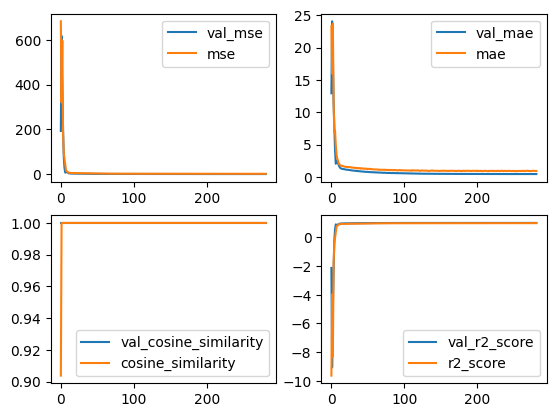

In [9]:
print(history.history.keys())
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history.history['val_mean_squared_error'])
axs[0, 0].plot(history.history['mean_squared_error'])
axs[0, 0].legend(['val_mse', 'mse'])

axs[0, 1].plot(history.history['val_mae'])
axs[0, 1].plot(history.history['mae'])
axs[0, 1].legend(['val_mae', 'mae'])

axs[1, 0].plot(history.history['val_cosine_similarity'])
axs[1, 0].plot(history.history['cosine_similarity'])
axs[1, 0].legend(['val_cosine_similarity', 'cosine_similarity'])

axs[1, 1].plot(history.history['val_r2_score'])
axs[1, 1].plot(history.history['r2_score'])
axs[1, 1].legend(['val_r2_score', 'r2_score'])

In [10]:
score = model.evaluate(test_x, test_y)
print(score[0])

14/14 [==============================] - 0s 3ms/step - loss: 0.5165 - mean_squared_error: 0.5165 - mae: 0.5091 - cosine_similarity: 1.0000 - r2_score: 0.9922
0.5165006518363953


In [11]:
print(test_x.dtypes)

Age                                   float64
Height                                float64
Weight                                float64
FCVC                                  float64
CAEC                                  float64
CH2O                                  float64
FAF                                   float64
CALC                                  float64
family_history_with_overweight_0.0    float64
family_history_with_overweight_1.0    float64
FAVC_0.0                              float64
FAVC_1.0                              float64
SCC_0.0                               float64
SCC_1.0                               float64
dtype: object


In [12]:
train_x = train.drop(columns=['label'])
train_y = train['label'].astype(float)

test_x = test_df.drop(columns=['label'])
test_y = test_df['label'].astype(float)
train_x = preproc_test_val(train_x, scaler, encoder)
test_x = preproc_test_val(test_x, scaler, encoder)

In [13]:
print(test_x.columns, train_x.columns)

Index(['Age', 'Height', 'Weight', 'FCVC', 'CAEC', 'CH2O', 'FAF', 'CALC',
       'family_history_with_overweight_0.0',
       'family_history_with_overweight_1.0', 'FAVC_0.0', 'FAVC_1.0', 'SCC_0.0',
       'SCC_1.0'],
      dtype='object') Index(['Age', 'Height', 'Weight', 'FCVC', 'CAEC', 'CH2O', 'FAF', 'CALC',
       'family_history_with_overweight_0.0',
       'family_history_with_overweight_1.0', 'FAVC_0.0', 'FAVC_1.0', 'SCC_0.0',
       'SCC_1.0'],
      dtype='object')


In [14]:
model = model_fn()

# Train the NN
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, min_delta=0.0001, restore_best_weights=True)

history = model.fit(train_x, train_y,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping_cb],
                    validation_data=(val_x, val_y))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1920      
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 76161 (297.50 KB)
Trainable params: 7616

dict_keys(['loss', 'mean_squared_error', 'mae', 'cosine_similarity', 'r2_score', 'val_loss', 'val_mean_squared_error', 'val_mae', 'val_cosine_similarity', 'val_r2_score'])


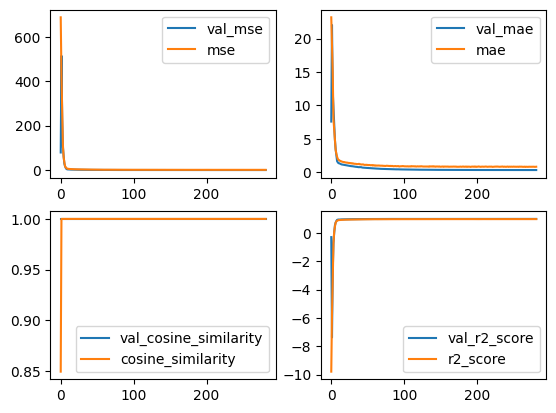

In [15]:
print(history.history.keys())
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history.history['val_mean_squared_error'])
axs[0, 0].plot(history.history['mean_squared_error'])
axs[0, 0].legend(['val_mse', 'mse'])

axs[0, 1].plot(history.history['val_mae'])
axs[0, 1].plot(history.history['mae'])
axs[0, 1].legend(['val_mae', 'mae'])

axs[1, 0].plot(history.history['val_cosine_similarity'])
axs[1, 0].plot(history.history['cosine_similarity'])
axs[1, 0].legend(['val_cosine_similarity', 'cosine_similarity'])

axs[1, 1].plot(history.history['val_r2_score'])
axs[1, 1].plot(history.history['r2_score'])
axs[1, 1].legend(['val_r2_score', 'r2_score'])

In [16]:
score = model.evaluate(test_x, test_y)

14/14 [==============================] - 0s 4ms/step - loss: 0.3575 - mean_squared_error: 0.3575 - mae: 0.3937 - cosine_similarity: 1.0000 - r2_score: 0.9946


In [17]:
train_df = pd.concat([train_x, train_y], axis=1)
train_df.to_csv('datasets/train_BMI.csv', index=False)
test_df = pd.concat([test_x, test_y], axis=1)
test_df.to_csv('datasets/test_BMI.csv', index=False)

model.save('models/titanic_model')
model.save_weights('models/titanic_weights')

INFO:tensorflow:Assets written to: models/titanic_model/assets


INFO:tensorflow:Assets written to: models/titanic_model/assets
